## Prediction of Density of States (DOS) using Partial Radial Distribution Function (PRDF) representation

We want to study the accuracy and time performance of the featurizations used in [Schutt et al paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.205118). Here in part 2, we build a Kernel Ridge Regression (KRR) model with three different kernels (Linear, Gaussian and Laplacian) and analyze accuracy of each kernel.

#### Import packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV, train_test_split

/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


#### Load featurized data from pickle file

In [2]:
path = os.path.join(os.getcwd(), 'schutt_cutoff10_binsize20.pkl')
data = pd.read_pickle(path)

In [3]:
print ("Shape of data: ", data.shape)
data.head(1)

Shape of data:  (6174, 12085)


,material_id,pretty_formula,structure,structure_obj,composition_obj,max_atom_num,max_orbital,dos_obj,dos,volume,...,He-Ne PRDF r=0.00-2.00,He-Ne PRDF r=2.00-4.00,He-Ne PRDF r=4.00-6.00,He-Ne PRDF r=6.00-8.00,He-Ne PRDF r=8.00-10.00,Ne-Ne PRDF r=0.00-2.00,Ne-Ne PRDF r=2.00-4.00,Ne-Ne PRDF r=4.00-6.00,Ne-Ne PRDF r=6.00-8.00,Ne-Ne PRDF r=8.00-10.00
0,mp-85,In,"{'@module': 'pymatgen.core.structure', '@class...",[[0. 0. 0.] In],(In),49,spd,Complete DOS for Full Formula (In1)\nReduced F...,0.0,27.560695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Count sp and spd systems

In [4]:
count = data['max_orbital'].value_counts(sort=True)

Partition compounds into $sp$ and $spd$ systems.

In Schutt's paper, there are 1716 sp systems and 5548 spd systems.

In [5]:
data = data.sort_values(by=['max_orbital'])

In [6]:
sp_data = data[:count['sp']]
spd_data = data[count['sp']:]
print ("sp systems: ", sp_data.shape[0])
print ("spd systems: ", spd_data.shape[0])

sp systems:  423
spd systems:  5751


Mean predictor of DOS in this data

In [7]:
print ("Mean predictor of sp system:", np.mean(np.abs(np.subtract(sp_data['dos'], np.mean(sp_data['dos']))))*100, "* 10^-2")
print ("Mean predictor of spd system:", np.mean(np.abs(np.subtract(spd_data['dos'], np.mean(spd_data['dos']))))*100, "* 10^-2")

Mean predictor of sp system: 0.13532102254725029 * 10^-2
Mean predictor of spd system: 0.14338560753567675 * 10^-2


Input X and Y

In [8]:
x_sp = sp_data.drop(['material_id', 'pretty_formula', 'structure', 'structure_obj',
       'composition_obj', 'max_atom_num', 'max_orbital', 'dos_obj', 'dos',
       'volume'], 1)
y_sp = sp_data['dos']

In [9]:
x_spd = spd_data.drop(['material_id', 'pretty_formula', 'structure', 'structure_obj',
       'composition_obj', 'max_atom_num', 'max_orbital', 'dos_obj', 'dos',
       'volume'], 1)
y_spd = spd_data['dos']

Partition data into training and testing set (80/20)

In [10]:
x_train, x_test, y_train, y_test = dict.fromkeys(['sp', 'spd']), dict.fromkeys(['sp', 'spd']), dict.fromkeys(['sp', 'spd']), dict.fromkeys(['sp', 'spd'])
x_train['sp'], x_test['sp'], y_train['sp'], y_test['sp'] = train_test_split(x_sp, y_sp, test_size=0.2, shuffle=True)
x_train['spd'], x_test['spd'], y_train['spd'], y_test['spd'] = train_test_split(x_spd, y_spd, test_size=0.2, shuffle=True)

### Build ML model

Set up Kernel Ridge Regression (KRR) model. Three types of kernel: linear, Gaussian, Laplacian

In [11]:
kernels = ['linear', 'gaussian', 'laplacian']

In [12]:
gamma = 5e-05
sp_models = {"linear": KernelRidge(kernel="linear"), 
             "gaussian": KernelRidge(kernel="rbf", alpha=1e-5, gamma=gamma), 
             "laplacian": KernelRidge(kernel="laplacian", alpha=1e-3, gamma=gamma)}
spd_models = {"linear": KernelRidge(kernel="linear"), 
              "gaussian": KernelRidge(kernel="rbf", alpha=1e-5, gamma=gamma), 
              "laplacian": KernelRidge(kernel="laplacian", alpha=1e-3, gamma=gamma)}

Here we'll compare the performance of three different kernels in predicting DOS for sp and spd systems.

In [13]:
kfold = KFold(5)

In [14]:
cv_prediction_sp, cv_prediction_spd = dict.fromkeys(kernels), dict.fromkeys(kernels)

In [15]:
for kernel in sp_models:
    sp_models[kernel] = sp_models[kernel].fit(x_train['sp'], y_train['sp'])
    cv_prediction_sp[kernel] = cross_val_predict(sp_models[kernel], x_test['sp'], y_test['sp'], cv=kfold)

In [16]:
for kernel in spd_models:
    spd_models[kernel] = spd_models[kernel].fit(x_train['spd'], y_train['spd'])
    cv_prediction_spd[kernel] = cross_val_predict(spd_models[kernel], x_test['spd'], y_test['spd'], cv=kfold)

Compute aggregate statistics of the kernels used.

In [17]:
stats = ['mean_absolute_error', 'mean_squared_error', 'r2_score']
score_sp, score_spd = dict.fromkeys(kernels), dict.fromkeys(kernels)
for i, j in zip(score_sp, score_spd):
    score_sp[i], score_spd[j] = dict.fromkeys(stats), dict.fromkeys(stats)

In [18]:
for model in kernels:
    for scorer in stats:
        score_sp[model][scorer] = getattr(metrics, scorer)(y_test['sp'], cv_prediction_sp[model])
        score_spd[model][scorer] = getattr(metrics, scorer)(y_test['spd'], cv_prediction_spd[model])

In [19]:
print ("sp system score: ")
for i in score_sp:
    print (i, ": ", score_sp[i])
print ()
print ("spd system score: ")
for i in score_spd:
    print (i, ": ", score_spd[i])

sp system score: 
linear :  {'mean_absolute_error': 0.000973534279832662, 'mean_squared_error': 3.6760321225768484e-06, 'r2_score': -0.23524186659244695}
gaussian :  {'mean_absolute_error': 0.0011336026313307258, 'mean_squared_error': 2.954286414905311e-06, 'r2_score': 0.007283357731307394}
laplacian :  {'mean_absolute_error': 0.0011437233989470131, 'mean_squared_error': 2.968260456143666e-06, 'r2_score': 0.0025877184638775086}

spd system score: 
linear :  {'mean_absolute_error': 0.0014202040362778989, 'mean_squared_error': 7.539538506544424e-06, 'r2_score': -0.21439641466034964}
gaussian :  {'mean_absolute_error': 0.0013330439338732915, 'mean_squared_error': 5.672388793185821e-06, 'r2_score': 0.08634611959006899}
laplacian :  {'mean_absolute_error': 0.0013933190972489637, 'mean_squared_error': 5.919866180326963e-06, 'r2_score': 0.0464848400975848}


Plot prediction

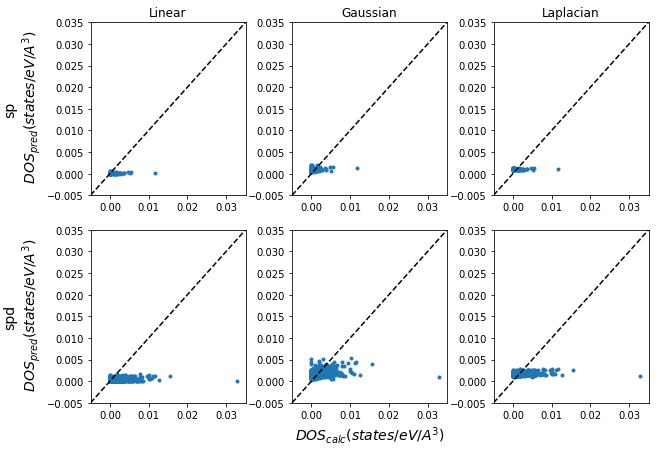

In [20]:
fig, ax = plt.subplots(2, 3)

ax[0, 0].set_title("Linear")
ax[0, 1].set_title("Gaussian")
ax[0, 2].set_title("Laplacian")

ax[0, 0].set_ylabel("sp\n $DOS_{pred} (states/eV/A^3)$", fontsize=14)
ax[1, 0].set_ylabel("spd\n $DOS_{pred} (states/eV/A^3)$", fontsize=14)
ax[1, 1].set_xlabel("$DOS_{calc} (states/eV/A^3)$", fontsize=14)

ax[0, 0].scatter(y_test['sp'], cv_prediction_sp['linear'], marker='.')
ax[0, 1].scatter(y_test['sp'], cv_prediction_sp['gaussian'], marker='.')
ax[0, 2].scatter(y_test['sp'], cv_prediction_sp['laplacian'], marker='.')

ax[1, 0].scatter(y_test['spd'], cv_prediction_spd['linear'], marker='.')
ax[1, 1].scatter(y_test['spd'], cv_prediction_spd['gaussian'], marker='.')
ax[1, 2].scatter(y_test['spd'], cv_prediction_spd['laplacian'], marker='.')

for i in range(2):
    for j in range(3):
        ax[i, j].set_xlim([-0.005, 0.035])
        ax[i, j].set_ylim([-0.005, 0.035])
        ax[i, j].plot(ax[i, j].get_xlim(), ax[i, j].get_xlim(), 'k--')

fig.subplots_adjust(wspace=0.3, hspace=0.2)
fig.set_size_inches((10, 7))